# Example: Let's do an Out-of-Sample (OOS) Single Asset Simulation
In this example, we will perform out-of-sample simulations of a single asset's share price using the Geometric Brownian Motion (GBM) model. Out-of-sample testing means evaluating the model on data __not used during parameter estimation__ to assess its predictive performance. We will use historical parameters estimated from past data to simulate future price trajectories and compare these simulations with actual market data.

> __Learning Objectives:__
>
> By the end of this example, you should be able to:
> * __Perform out-of-sample GBM simulations__: Learn how to use historical parameters to simulate future share price trajectories for a single asset using the geometric Brownian motion model, and understand why out-of-sample testing is crucial for assessing real-world predictive performance.
> * __Compute analytical moments__: Calculate the expected value and variance of share prices at future times using analytical expressions derived from the GBM model, and compare these with Monte Carlo simulation estimates.
> * __Compare simulations with actual data__: Visualize simulated price paths alongside actual market data to assess model performance, understand uncertainty through confidence intervals, and identify potential model limitations.

This is going to be cool, so let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `09-26-2025`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [2]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 482 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days to ensure we have consistent, complete time series for reliable analysis.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

182

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

In [5]:
dataset["BAC"]

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,2.34557e7,44.5869,44.75,44.81,44.85,44.15,2025-01-03T05:00:00,122903
2,3.05185e7,45.5447,45.155,45.4,46.15,45.0999,2025-01-06T05:00:00,165613
3,4.11112e7,46.1478,46.28,46.08,46.65,45.65,2025-01-07T05:00:00,210109
4,4.0246e7,46.0893,45.9,46.21,46.26,45.69,2025-01-08T05:00:00,171459
5,4.07413e7,45.1549,46.0,45.11,46.05,44.735,2025-01-10T05:00:00,181779
6,3.43536e7,45.0028,45.1,45.06,45.34,44.69,2025-01-13T05:00:00,155942
7,3.6379e7,45.6647,45.6,45.78,45.92,45.23,2025-01-14T05:00:00,181374
8,5.71548e7,47.1729,47.12,47.1,47.46,46.84,2025-01-15T05:00:00,245580
9,5.63393e7,46.6272,47.0,46.64,47.51,45.82,2025-01-16T05:00:00,264885


Next, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [6]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

Now, let's load the GBM parameters that we computed in the previous example:

In [7]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end

Row,ticker,drift,t,lower_bound_drift,upper_bound_drift,volatility
,String7,Float64,Float64,Float64,Float64,Float64
1,A,0.147468,1.96,0.145161,0.149774,0.231426
2,AAL,-0.141294,1.96,-0.1436,-0.138988,0.454992
3,AAP,-0.0481021,1.96,-0.0504085,-0.0457958,0.342562
4,AAPL,0.24271,1.96,0.240403,0.245016,0.234474
5,ABBV,0.116,1.96,0.113693,0.118306,0.242938
6,ABT,0.123083,1.96,0.120777,0.125389,0.199723
7,ACN,0.151012,1.96,0.148706,0.153319,0.214367
8,ADBE,0.224401,1.96,0.222094,0.226707,0.276273
9,ADI,0.146449,1.96,0.144142,0.148755,0.259329


### Constants and Parameters
Let's define some constants and parameters that we will use in our simulations. See the comments next to each constant for additional information, including values, units, etc.

In [8]:
Δt = (1.0/252.0); # time step (1 trading day, in years)
TSIM = 182; # number of trading days to simulate (1 quarter, in trading days)

___

In [9]:
parameters_df

Row,ticker,drift,t,lower_bound_drift,upper_bound_drift,volatility
,String7,Float64,Float64,Float64,Float64,Float64
1,A,0.147468,1.96,0.145161,0.149774,0.231426
2,AAL,-0.141294,1.96,-0.1436,-0.138988,0.454992
3,AAP,-0.0481021,1.96,-0.0504085,-0.0457958,0.342562
4,AAPL,0.24271,1.96,0.240403,0.245016,0.234474
5,ABBV,0.116,1.96,0.113693,0.118306,0.242938
6,ABT,0.123083,1.96,0.120777,0.125389,0.199723
7,ACN,0.151012,1.96,0.148706,0.153319,0.214367
8,ADBE,0.224401,1.96,0.222094,0.226707,0.276273
9,ADI,0.146449,1.96,0.144142,0.148755,0.259329


## Task 1: Simulate Future Prices
In this task, we will simulate future prices for a single asset using the Geometric Brownian Motion (GBM) model. We will use the parameters we computed earlier to generate these simulations.

Let's start by selecting a ticker symbol from our list of tickers, save this value in the `ticker_to_simulate::String` variable:

In [10]:
ticker_to_simulate = "SPY"; # select a ticker symbol from the list_of_tickers array (DPZ = Domino's Pizza)
random_firm_data = dataset[ticker_to_simulate]; # extract the data for this ticker

Next, let's extract the initial share price, save this value in the `Sₒ::Float64` variable:

In [11]:
Sₒ = let

    # initialize -
    i = findfirst(x-> x == ticker_to_simulate, list_of_tickers); # find index of ticker to simulate
    data = dataset[ticker_to_simulate]; # extract the data for this ticker
    Sₒ = data[1,:close]; # extract the initial share price
    Sₒ; # return
end;

### Generate sample price trajectories for a GBM model
Create an instance of [the `MyGeometricBrownianMotionEquityModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) using a custom [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 

We pass the model type to the `build(...)` method along with the growth and volatility parameters. The `build(...)` method returns the GBM model instance, which we store in the `model::MyGeometricBrownianMotionEquityModel` variable.

In [12]:
model = let

    # initialize -
    i = findfirst(x-> x == ticker_to_simulate, list_of_tickers);
    μ̂ = parameters_df[i, :drift]; # extract drift parameter (estimated growth rate)
    σ̂ = parameters_df[i, :volatility]; # extract volatility parameter (estimated price fluctuation)

    # build model -
    model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

    model; # return
end;

Next, let's compute the simulated future prices using the GBM model. 

In [13]:
X, T₁, T₂ = let

    T₁ = 1*Δt # start time (1 trading day, in years)
    T₂ = TSIM*Δt
    number_of_paths = 100; # number of sample paths to generate

    # generate sample paths using the GBM model
    X = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
            number_of_paths = number_of_paths);

    X, T₁, T₂; # return
end;

In addition to the numerical samples, we have analytical expressions for both the expected value and the variance of the share price. We've implemented the analytical expectation and variance calculations in the `expectation(...)` and `variance(...)` functions. 

Let's call these functions to get analytical values for the expectation and variance of the share price.

In [14]:
expectation_array = expectation(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance_array = variance(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

`Unhide` the block below to see how to plot the expected value and confidence bands of the simulated share price alongside the actual market data and sampled trajectories. This visualization helps assess how well the GBM model captures the uncertainty in future price movements.

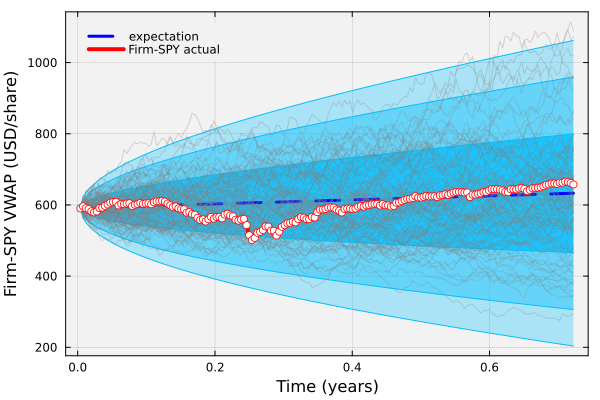

In [15]:
let
    
    # Initialize -
    start_index = 1;
    stop_index = TSIM;
    random_firm_ticker = ticker_to_simulate;
    L68 = expectation_array[:,2] .- sqrt.(variance_array[:,2])
    U68 = expectation_array[:,2] .+ sqrt.(variance_array[:,2])
    L95 = expectation_array[:,2] .- 1.96*sqrt.(variance_array[:,2])
    U95 = expectation_array[:,2] .+ 1.96*sqrt.(variance_array[:,2])
    L99 = expectation_array[:,2] .- 2.576*sqrt.(variance_array[:,2])
    U99 = expectation_array[:,2] .+ 2.576*sqrt.(variance_array[:,2])

    # Plot confidence bands: 68% (1σ), 95% (1.96σ), and 99% (2.576σ) around the expected price trajectory
    plot(expectation_array[:,1], expectation_array[:,2], fillrange=L68, c=:deepskyblue1, alpha=0.75, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U68, c=:deepskyblue1, alpha=0.75, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=L95, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U95, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=L99, c=:deepskyblue1, alpha=0.3, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U99, c=:deepskyblue1, alpha=0.3, label="")

    plot!(expectation_array[:,1], expectation_array[:,2],c=:blue, lw=3,ls=:dash, label="expectation")
    plot!(expectation_array[:,1], L68, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U68, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], L95, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U95, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], L99, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U99, c=:deepskyblue1, lw=1, label="")
    plot!(X[:,1],X[:,2:end], label="", c=:gray, alpha=0.3)
    plot!(X[:,1], random_firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
        label="Firm-$(random_firm_ticker) actual")
     scatter!(X[1:end,1], random_firm_data[start_index:stop_index, :volume_weighted_average_price], label="", 
         msc=:red, mc=:white)


    xlabel!("Time (years)", fontsize=18)
    ylabel!("Firm-$(random_firm_ticker) VWAP (USD/share)", fontsize=18)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

___

## Summary
In this example, we performed out-of-sample simulations of a single asset's share price using the Geometric Brownian Motion (GBM) model. 

> __Key Takeaways:__
> * __GBM works for stable assets__: The geometric Brownian motion model performs well for "well-mannered" tickers with relatively stable parameters over time, providing reasonable out-of-sample predictions within confidence intervals.
> * __Model fails with regime changes__: For assets experiencing shifts in parameters (e.g., changes in drift sign, sudden volatility spikes from news events), single asset GBM fails completely as it assumes constant parameters.
> * __Regime change requires advanced approaches__: Cases of structural breaks or regime changes necessitate more sophisticated models, e.g., time-varying parameter models that we'll explore in future lectures.

___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

___